In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
from collections import Counter
from multiset import Multiset 
from tqdm import tqdm
import os, time, psutil

In [5]:
process = psutil.Process(os.getpid())

In [6]:
class KMeans_with_count:

    def __init__(self, k, thres = 0.1, max_iter = 10, random_seed = 100) -> None:
        self.data = {}
        self.D = 0
        self.content = None   
        self.max_k = k  
        self.thres = thres
        self.max_iter = max_iter
        self.random_seed = random_seed


    def store_data(self, k):
        self.data = {}
        for item in content[3:]:
            temp = list(map(int,item.split(" ")))
            docID = temp[0]
            wordID = temp[1]
            cntID = temp[2]
            if docID in self.data.keys() : 
                self.data[docID][wordID] = cntID
            else:
                self.data[docID] = {}
                self.data[docID][wordID] = cntID 

        random.seed(self.random_seed)   
        centroid = random.sample(list(self.data.keys()), k = k)
        centroid_data = {c : self.data[c] for c in centroid}              # Stores Random State 
        return centroid, centroid_data
    

    def jac_dist(self, centroid, point, centroid_data, og_data = None):
        if og_data == None:
            og_data = self.data
        inter_1 = Multiset(centroid_data[centroid])
        inter_2 = Multiset(og_data[point])
        union_1 = inter_1.copy()                                           #Multiset(centroid_data[keys1])
        union_2 = inter_2.copy()

        inter_1.intersection(inter_2)
        union_1.union_update(union_2)

        return 1- len(inter_1) / len(union_1)
    

    def check(self, centroid, centroid_new):
        total = 0
        for i in range(len(centroid)):
            key_1 = list(centroid.keys())[i]
            key_2 = list(centroid_new.keys())[i]
            total += self.jac_dist(key_1, key_2, centroid, centroid_new)
        if total <= self.thres:
            return True


    def create_clusters(self,centroid, centroid_data):
        inertia = 0
        my_cluster = {}
        words = {}

        for keys in self.data.keys():
            minimum = 200
            cntrd = None
            
            for clt in centroid:
                dist = self.jac_dist(clt, keys, centroid_data)
                if minimum > dist:
                    minimum = dist
                    cntrd = clt
            
            if cntrd == None:                                                 # Problem to encounter 
                cntrd = centroid.keys()[0]

            inertia += minimum
            if cntrd in my_cluster.keys():
                my_cluster[cntrd].append(keys)
            else:
                my_cluster[cntrd] = []
                my_cluster[cntrd].append(keys)
            
            temp = []
            for k,v in self.data[keys].items():
                temp += [k]*v
            
            if cntrd in words.keys():
                words[cntrd] += temp
            else:
                words[cntrd] = temp
        return my_cluster, inertia, words


    def update_centroid(self,my_cluster, words):
        centroid = []
        centroid_data = {}

        for clt in my_cluster.keys():
            n = int(len(words[clt])/(len(my_cluster[clt])))
            temp = {}
            count_words = Counter(words[clt])
            words_list = count_words.most_common(n)

            for w, c in words_list:
                w_counter = 0
                for _ in my_cluster[clt] :
                    if w in self.data[_].keys():
                        w_counter += 1
                temp[w] = int(c/w_counter)

            self.D += 1
            centroid_data[self.D] = temp
            self.data[self.D] = temp 
            centroid.append(self.D)
        return centroid, centroid_data
    

    def main(self, content):
        with open(f"data/docword.{content}.txt") as XYZ:                                 
            self.content = XYZ.readlines()
        self.D = int(self.content[0].replace('\n',""))
        k_means = {}

        for k in tqdm(range(2,self.max_k+1)): 
            centroid,centroid_data = self.store_data(k)                     
            for _ in range(self.max_iter):
                my_clusters, inertia, words = self.create_clusters(centroid,centroid_data)
                centroid_new, centroid_data_new = self.update_centroid(my_clusters, words)
                if self.check(centroid_data, centroid_data_new):
                    break
                centroid, centroid_data = centroid_new, centroid_data_new
            k_means[k] = inertia

        plt.figure(figsize=(8,5))  
        plt.plot(k_means.keys(), k_means.values(), marker='o', linestyle='-', 
                color='b', markerfacecolor='#ff7f0e', markersize=7)  
        plt.xlabel("Number of Clusters (K)", fontsize=11)  
        plt.ylabel("Inertia", fontsize=11)  
        plt.title(f"Inertia vs Number of Clusters for {content}", fontsize=12)  
        plt.xticks(fontsize=8) 
        plt.yticks(fontsize=8)  
        plt.grid(True, linestyle='--', alpha=0.7)  
        plt.tight_layout()  
        plt.show()

In [ ]:
""" Update centroid : this is still doing the same i.e considering all the words. 
    Idea was to take lesser no. of or avg no. of words """

""" Updated : Now it takes avg no. of words and avg no. of words = sum(freq of top words we are choosing) 
    Also, it stores the avg frequency of each word i.e. ( sum of freq / count of doc in which word occured ) """

#Approach 1 :

""" def update_centroid(self,my_cluster, words):
    centroid = []
    centroid_data = {}
    for clt in my_cluster.keys():
        count_n = int(len(words[clt])/(len(my_cluster[clt]))) + 1 
        temp = {}
        count_words = dict(Counter(words[clt]))
        top_words = count_words.most_common(len(count_words))
        for k,v in top_words:
            if count_n - v > 0 and count:               # can adjust a little bit by modultaion of no. of words considered
                temp[k] = v
                count_n -= v 
            else:
                    break    
        print(temp)                  
        self.D += 1
        centroid_data[self.D] = temp
        self.data[self.D] = temp 
        centroid.append(self.D)
    return centroid, centroid_data
 """

# Approach 2:

""" def update_centroid(self,my_cluster, words):
    centroid = []
    centroid_data = {}

    for clt in my_cluster.keys():
        n = int(len(words[clt])/(len(my_cluster[clt])))
        temp = {}
        count_words = Counter(words[clt])
        words_list = count_words.most_common(n)

        for w, c in words_list:
            temp[w] = int(c/(len(my_cluster[clt])))

        self.D += 1
        centroid_data[self.D] = temp
        self.data[self.D] = temp 
        centroid.append(self.D)
    return centroid, centroid_data
"""

# Final Approach : 

""" def update_centroid(self,my_cluster, words):
    centroid = []
    centroid_data = {}

    for clt in my_cluster.keys():
        n = int(len(words[clt])/(len(my_cluster[clt])))
        temp = {}
        count_words = Counter(words[clt])
        words_list = count_words.most_common(n)

        for w, c in words_list:
            w_counter = 0
            for _ in my_cluster[clt] :
                if w in self.data[_].keys():
                    w_counter += 1
            temp[w] = int(c/w_counter)

        self.D += 1
        centroid_data[self.D] = temp
        self.data[self.D] = temp 
        centroid.append(self.D)
    return centroid, centroid_data """

##### a) KOS

In [12]:
threshold = 0.05
seed = 100
obj = KMeans_with_count(12,threshold,max_iter=5,random_seed=seed)

100%|██████████| 11/11 [02:17<00:00, 12.48s/it]


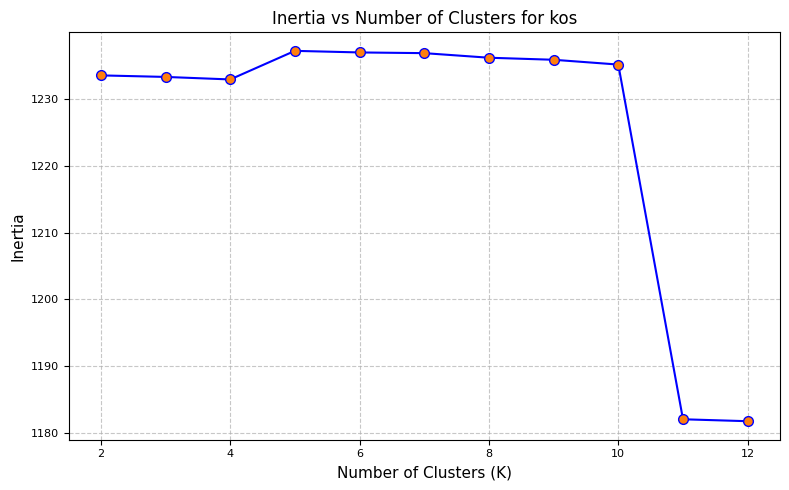

Results for Threshold = 0.05 and seed = 100
Space taken: 40788.0 KB
Time taken: 137.52540826797485 seconds


In [13]:
start_time = time.time()
start_mem = process.memory_info().rss
obj.main('kos')
end_mem = process.memory_info().rss
print(f"Results for Threshold = {threshold} and seed = {seed}")
print(f'Space taken: {round(end_mem - start_mem)/1024} KB')
end_time = time.time()
print("Time taken:", (end_time - start_time), "seconds")

##### b) enron

In [24]:
threshold = 0.2
seed = 67
obj = KMeans_with_count(10,threshold,max_iter=100,random_seed=seed)

100%|██████████| 9/9 [00:44<00:00,  4.95s/it]


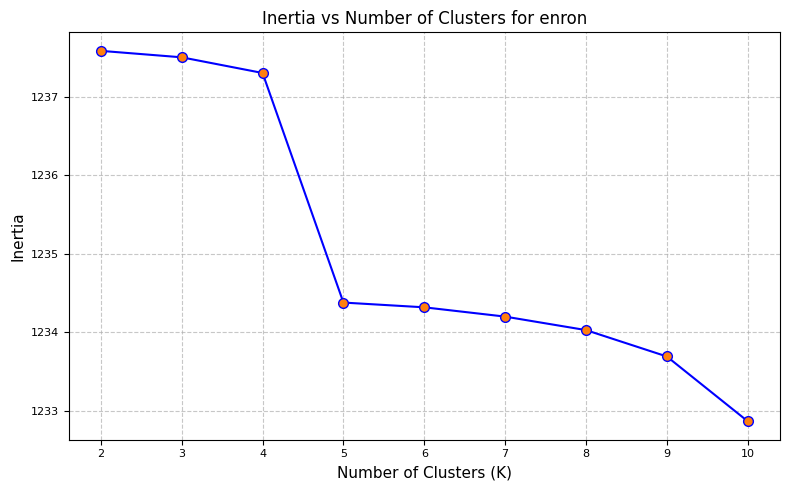

Results for Threshold = 0.2 and seed = 67
Space taken: 220912.0 KB
Time taken: 45 seconds


In [25]:
start_time = time.time()
start_mem = process.memory_info().rss
obj.main('enron')
end_mem = process.memory_info().rss
print(f"Results for Threshold = {threshold} and seed = {seed}")
print(f'Space taken: {round(end_mem - start_mem)/1024} KB')
end_time = time.time()
print("Time taken:", round(end_time - start_time), "seconds")

##### c) NIPS

In [28]:
threshold = 0.2
seed = 14
obj = KMeans_with_count(11,threshold,max_iter=100,random_seed=seed)

100%|██████████| 10/10 [01:34<00:00,  9.40s/it]


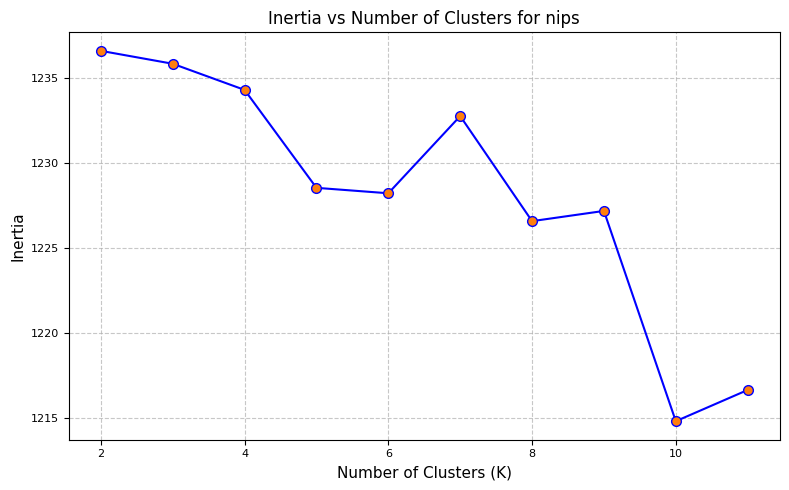

Results for Threshold = 0.2 and seed = 14
Space taken: 15708.0 KB
Time taken: 94 seconds


In [29]:
start_time = time.time()
start_mem = process.memory_info().rss
obj.main('nips')
end_mem = process.memory_info().rss
print(f"Results for Threshold = {threshold} and seed = {seed}")
print(f'Space taken: {round(end_mem - start_mem)/1024} KB')
end_time = time.time()
print("Time taken:", round(end_time - start_time), "seconds")

##### End - Look into Readme.md for explanation